
# Measure AUC on Test Dataset for IML Challenge

This notebook extracts the AUC of your method measured on the test dataset. Please read the challenge instructions for further information.

## Set up TMVA

In [1]:
import ROOT

# Set up TMVA reader
reader = ROOT.TMVA.Reader("Color:!Silent")

Welcome to JupyROOT 6.08/06


## Load data

**NOTE:** You have to preprocess the modified data, similar to what was done for the "standard" data in the TMVAClassification notebook.   
In order to do that, please run `sh PREPROCESS_DATA_MODIFIED` in a terminal.


In [3]:
# NOTE: Check out the `preprocess_data.py` script shipped with this notebook!

data = ROOT.TFile("preprocessed_data_modified.root")
if data == None:
    raise Exception('Have you run the preprocessing? Can not open file: {}'.format(filename))

quarks = data.Get('quarks')
gluons = data.Get('gluons')


## Declare variables

You have to declare which variables you want to use for the application.

In [4]:
from array import array

branches = {}
for branch in quarks.GetListOfBranches():
    branchName = branch.GetName()
    if not '_' in branchName: # NOTE: This selection has to be the same as used during training!
        branches[branchName] = array('f', [-999])
        reader.AddVariable(branchName, branches[branchName])
        quarks.SetBranchAddress(branchName, branches[branchName])
        gluons.SetBranchAddress(branchName, branches[branchName])

## Book method

Point here to the weight file of the method you want to use.

In [5]:
# Book Fisher method
reader.BookMVA('Fisher', ROOT.TString('TMVAClassification/weights/TMVAClassification_Fisher.weights.xml'))

<ROOT.TMVA::MethodFisher object ("Fisher") at 0x5a7c5d0>

                         : Booking "Fisher" of type "Fisher" from TMVAClassification/weights/TMVAClassification_Fisher.weights.xml.
DataSetInfo              : [Default] : Added class "quarks"
DataSetInfo              : [Default] : Added class "gluons"
                         : Booked classifier "Fisher" of type: "Fisher"


## Classify data

In [6]:
import numpy as np

# Classify quarks
mvaValues_quarks = np.zeros(quarks.GetEntries())
for i in range(quarks.GetEntries()):
    quarks.GetEntry(i)
    mvaValues_quarks[i] = reader.EvaluateMVA('Fisher')

# Classify gluons
mvaValues_gluons = np.zeros(gluons.GetEntries())
for i in range(gluons.GetEntries()):
    gluons.GetEntry(i)
    mvaValues_gluons[i] = reader.EvaluateMVA('Fisher')

## Calculate area-under-curve (AUC)

In [7]:
from sklearn import metrics

# Calculate ROC
y_true = np.hstack((np.ones(quarks.GetEntries()), np.zeros(gluons.GetEntries())))
y_score = np.hstack((mvaValues_quarks, mvaValues_gluons))
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)

# Get AUC from ROC
auc = metrics.auc(fpr, tpr)
print('AUC: {}'.format(auc))

AUC: 0.769851399475


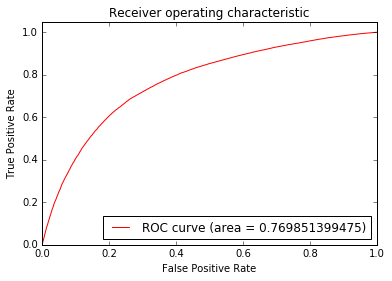

In [8]:
# Plot ROC

import matplotlib.pyplot as plt
# Enable Javascript magic for matplotlib
%matplotlib inline

plt.figure()
plt.plot(fpr, tpr, color='red', label='ROC curve (area = {})'.format(auc))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=0)
plt.show()

In [10]:
# Save AUC value
f = open("imlcoordinators_v2_auc.txt","w") 
f.write(str(auc))
f.close()